# Разработка решения для повышения покупательской активности клиентов магазина "В один клик"

## Введение

**Общее описание проекта:** Заказчик - Интернет-магазин «В один клик». Он продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель проекта:** Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных:** 
В нашем распоряжении 4 файла с данными:

1. Файл `market_file.csv` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Описание столбцов:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности **(целевой признак)**: «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

2. Файл `market_money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Описание столбцов:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

3. Файл `market_time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода. Описание столбцов:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

4. Файл `money.csv` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Описание столбцов:
- `id` — номер покупателя в корпоративной базе данных
- `Прибыль` — значение прибыли.

**План работы:**
- Загрузка данных, предобработка данных (обработка пропусков, дубликатов, типов данных, названий столбцов)
- Исследовательский анализ данных (в том числе отбор клиентов с покупательской способностью не менее 3 месяцев - они что-то покупали за этот период)
- Объединение данных в единую таблицу (за исключением money.csv)
- Корреляционный анализ данных
- Обучение моделей с использованием пайплайнов
- Анализ важности признаков
- Сегментация покупателей
- Оформление общего вывода

In [1]:
!pip install -U scikit-learn
!pip install shap
!pip install phik

In [2]:
# Опционально: убираем все предупреждения
import warnings
warnings.filterwarnings("ignore")

# Необходимые импорты
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    fbeta_score,
    make_scorer
)

import shap
import phik
from phik import phik_matrix

## Загрузка данных
Загрузим данные, посмотрим на первые строки таблиц и проверим, соответствуют ли данные заявленному описанию

In [3]:
# Считывание данных

market_df = pd.read_csv('https://drive.google.com/uc?export=download&id=19CkVU0370_wbjRf5e761VA79XhiBdTZG')
market_money_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1zwc-O_zQIxfZr9ZZPU1LDs_M_4GL-yqT')
market_time_df = pd.read_csv('https://drive.google.com/uc?export=download&id=11nkHk3jkM7XBSJm1hpbDTI6dr5L7oXMh')
money_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1DGNxIqac1rjhbYYn5nG5gF7PJDJoteT9',sep=';', decimal=',')

#### market_df

In [4]:
market_df.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [5]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Данные соответствуют описанию. 

#### market_money_df

In [6]:
market_money_df.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [7]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Данные соответствуют описанию.

#### market_time_df

In [8]:
market_time_df.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [9]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Данные соответствуют описанию.

#### money_df

In [10]:
money_df.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


In [11]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Данные соответствуют описанию. Обратим внимание, что показатель прибыли измеряется в процентах (от выручки)

**Вывод:** Данные соответствуют описанию. В данных отсутствуют пропуски. Типы данных оптимальны. Обратим внимание, что в данных есть неявные дубликаты (изучим и устраним их на этапе Предобработки)

## Предобработка данных

Так как в ходе знакомства с данными мы выяснили, что в данных отсутствуют пропущенные значения, а типы данных - оптимальны, предобработка будет состоять всего из двух шагов:
1. Обработаем названия столбцов
2. Обработаем явные и неявные дубликаты

### Обработка названий столбцов

#### market_df

In [12]:
market_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [13]:
market_df.columns = [
    'id', 'purch_activity', 'service_type',
    'ads_allowed', '6_months_activity',
    'current_month_activity', 'duration',
    'share_of_promo', 'popular_category',
    'avg_cat_viewed', 'unpaid_items',
    'service_error', 'pages_per_visit'
]
market_df.head()

,id,purch_activity,service_type,ads_allowed,6_months_activity,current_month_activity,duration,share_of_promo,popular_category,avg_cat_viewed,unpaid_items,service_error,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Названия столбцов обработаны.

#### market_money_df

In [14]:
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [15]:
market_money_df.columns = [
    'id', 'period', 'revenue'
]
market_money_df.head()

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Названия столбцов обработаны.

#### market_time_df

In [16]:
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [17]:
market_time_df.columns = [
    'id', 'period', 'minutes'
]
market_time_df.head()

,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Названия столбцов обработаны.

#### money_df

In [18]:
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [19]:
money_df.columns = [
    'id', 'profit'
]
money_df.head()

,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Названия столбцов обработаны.

### Обработка дубликатов

Сначала разберемся с явными дубликатами.

In [20]:
# Для более быстрой проверки на дубликаты, используем цикл
for i in range(0, 4):
    df_list = [market_df, market_money_df, market_time_df, money_df]
    names_list = ['market_df', 'market_money_df', 'market_time_df', 'money_df']
    print(f'Количество явных дубликатов в {names_list[i]} равно {df_list[i].duplicated().sum()}')

Количество явных дубликатов в market_df равно 0
Количество явных дубликатов в market_money_df равно 0
Количество явных дубликатов в market_time_df равно 0
Количество явных дубликатов в money_df равно 0


Явные дубликаты отсутствуют

Теперь устраним неявные дубликаты.

**market_df**

In [21]:
for column in market_df.select_dtypes(exclude='number'):
    print(f'{column}: {market_df[column].unique()}')

purch_activity: ['Снизилась' 'Прежний уровень']
service_type: ['премиум' 'стандартт' 'стандарт']
ads_allowed: ['да' 'нет']
popular_category: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [22]:
market_df.loc[market_df['service_type'] == 'стандартт', 'service_type'] = 'стандарт'
for column in market_df.select_dtypes(exclude='number'):
    print(f'{column}: {market_df[column].unique()}')

purch_activity: ['Снизилась' 'Прежний уровень']
service_type: ['премиум' 'стандарт']
ads_allowed: ['да' 'нет']
popular_category: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Неявные дубликаты устранены.

**market_money_df**

В таблице только одна колонка со строковыми значениями - период, проверять дубликаты будем в ней

In [23]:
market_money_df['period'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Неявные дубликаты отсутствуют, 'препредыдущий месяц' считаем месяцем, который идет до предыдущего.

In [24]:
market_time_df['period'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [25]:
market_time_df.loc[market_time_df['period'] == 'предыдцщий_месяц', 'period'] = 'предыдущий_месяц'
market_time_df['period'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Неявные дубликаты отсутствуют, но исправим опечатку 'предыдцщий_месяц' на значение 'предыдущий_месяц'.

В **money_df** нет колонок со строковыми значениями, поэтому можем двигаться дальше. Но сначала еще раз проверим, не появились ли в данных явные дубликаты после устранения неявных.

In [26]:
for i in range(0, 4):
    df_list = [market_df, market_money_df, market_time_df, money_df]
    names_list = ['market_df', 'market_money_df', 'market_time_df', 'money_df']
    print(f'Количество явных дубликатов в {names_list[i]} равно {df_list[i].duplicated().sum()}')

Количество явных дубликатов в market_df равно 0
Количество явных дубликатов в market_money_df равно 0
Количество явных дубликатов в market_time_df равно 0
Количество явных дубликатов в money_df равно 0


Дубликаты в данных отсутствуют.

In [27]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Общий вывод по Предобработке данных:**
- В данных отсутствуют пропущенные значения
- Обработаны неявные дубликаты и опечатки
- В данных отсутствуют явные дубликаты
- Названия столбцов приведены в приемлемый вид для более простого использования в дальнейшем

## Исследовательский анализ данных

Проведем исследовательский анализ данных всех признаков. Отберем клиентов с покупательской активностью не менее трёх месяцев (таких, которые что-либо покупали в этот период).

### market_df

Начнем с изучения количественных признаков. Выведем их распределения и изучим каждое.

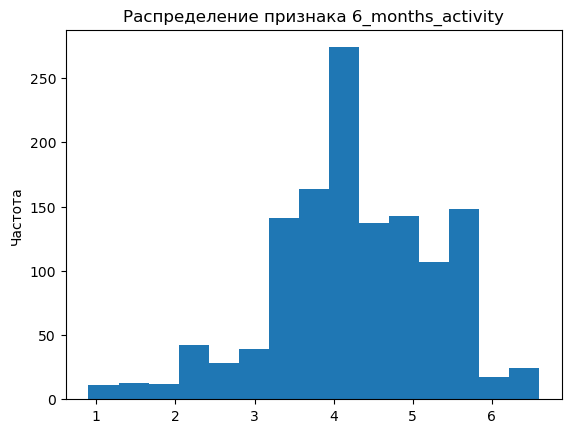

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: 6_months_activity, dtype: float64


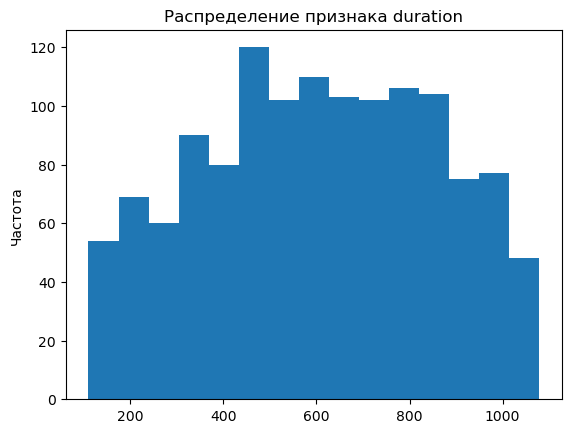

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: duration, dtype: float64


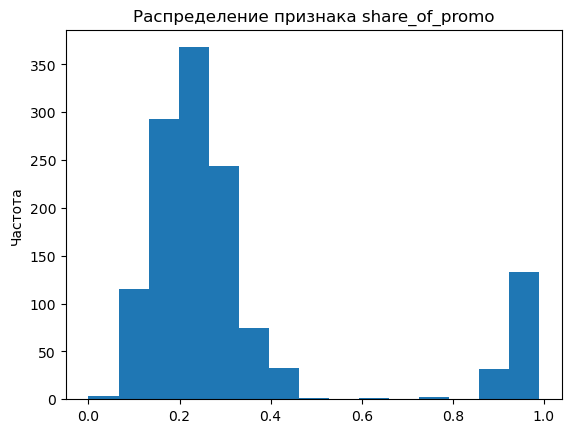

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: share_of_promo, dtype: float64


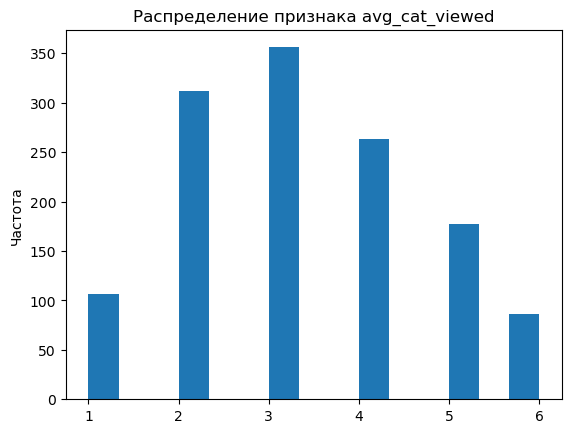

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: avg_cat_viewed, dtype: float64


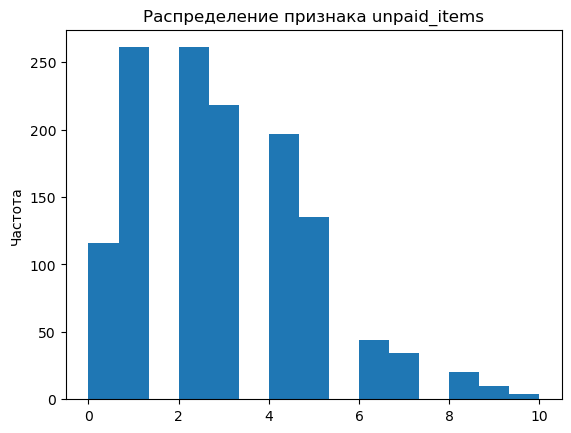

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_items, dtype: float64


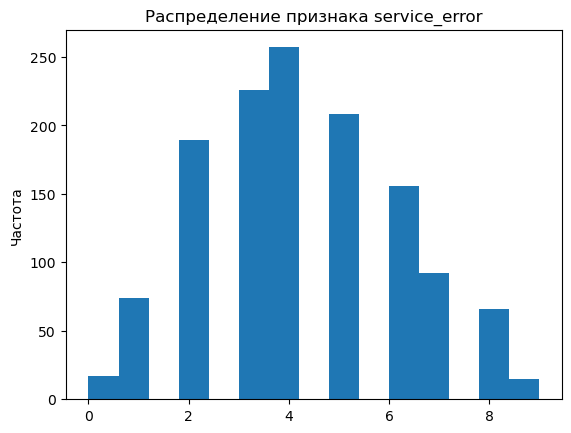

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: service_error, dtype: float64


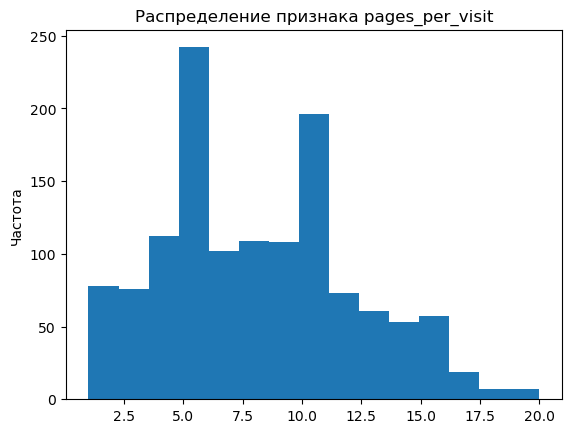

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_per_visit, dtype: float64


In [28]:
# Для более удобного отображения будем использовать функцию
def display_hist(df, feature):
    df[feature].plot(kind='hist', y=feature, bins=15)
    plt.title(f'Распределение признака {feature}')
    plt.ylabel('Частота')
    plt.show()
    print(df[feature].describe())

for feature in market_df.drop(['id', 'current_month_activity'], axis=1).select_dtypes(include='number'):
    display_hist(market_df, feature)

**Среднемесячное количество маркетинговых коммуникаций за 6 месяцев**
- Распределение имеет форму, не похожую на нормальное. Основная масса клиентов в среднем получают до 5.75 коммуникаций со сторроны сервиса (3й квартиль). Среднее значение 4.2, медиана также 4.2. На графике в этом диапазоне заметен пик, то есть значение 4.2 также является и модой. Обратим внимание, что клиенты редко получают в среднем больше 6 или меньше 2 маркетинговых взаимодействия со стороны сервиса.
- Выбросы и аномалии отсутствуют

**Количество дней, которое прошло с момента регистрации на сайте**
- По форме распределение напоминает нормально, со средним около 601, отсутствуют пики, выбросы и аномалии

**Доля акционных товаров среди всех покупок**
- В левой части графика находится большинство пользователей - них доля акционных товаров не превышает 0.3 (3й квартиль, 75%), само распределение походит на нормальное со средним 2.5, но есть также группа пользователей, у которых почти все купленные товары являются акционными (правая часть графика). Вероятно, это связано с тем, что у сайта есть пользователи, которые "охотятся" за акциями.
- Аномалии и выбросы отсутствуют

**Среднее количество просмотренных категорий**
- Распределение похоже на нормальное, со средним 3. Выбросы, аномалии отсутствуют

**Неоплаченные товары в корзине**
- Распределение похоже на нормальное со смещением влево, средним 2.8. Обратим внимание, что у большинства пользователей количество неоплаченных товаров в корзине не превышает 4 (75%)
- Выбросы и аномалии отсутствуют

**Сбои сервиса**
- Форма распределения напоминает нормальное, со средним 4.2. Аномальные значения и выбросы отсутствуют

**Среднее количество просмотренных страниц за визит**
- Форма распределения напоминает нормальное со средним 7.5, но два пика 5 и 11 не могут нам позволить так считать. Изучим эти данные детальнее.
- Большая часть пользователей (75%) не посещают в среднем более 11 страниц за визит.

Изучим пик, где среднее количество просмотренных страниц равно 5. Построим гистограммы распределения тех же признаков, что и для всех данных.

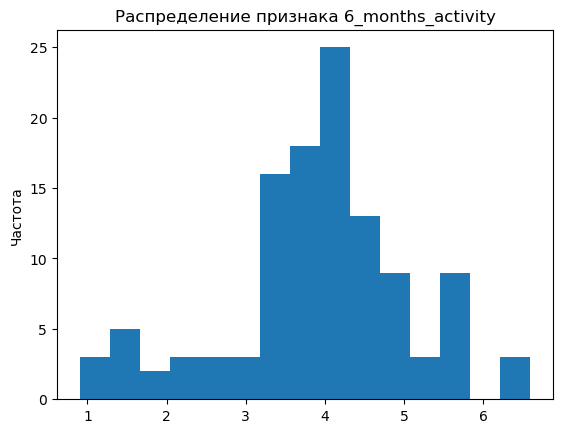

count    115.000000
mean       3.924348
std        1.143141
min        0.900000
25%        3.500000
50%        4.000000
75%        4.600000
max        6.600000
Name: 6_months_activity, dtype: float64


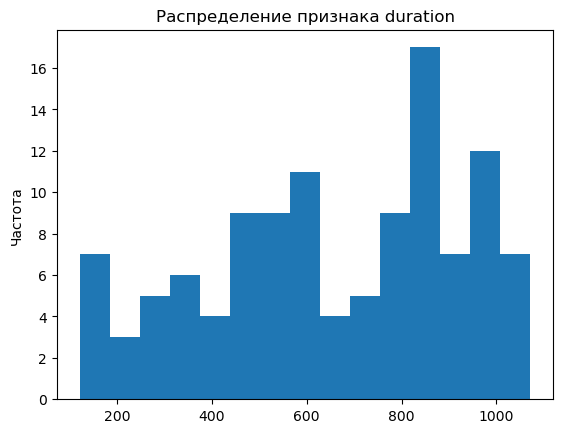

count     115.000000
mean      657.686957
std       264.088946
min       121.000000
25%       453.000000
50%       690.000000
75%       870.500000
max      1072.000000
Name: duration, dtype: float64


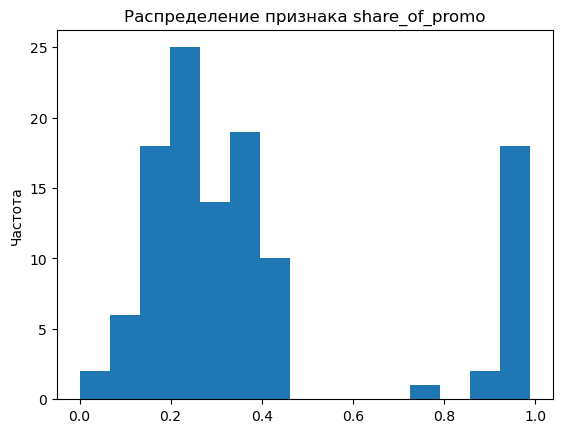

count    115.000000
mean       0.384696
std        0.281258
min        0.000000
25%        0.220000
50%        0.280000
75%        0.400000
max        0.990000
Name: share_of_promo, dtype: float64


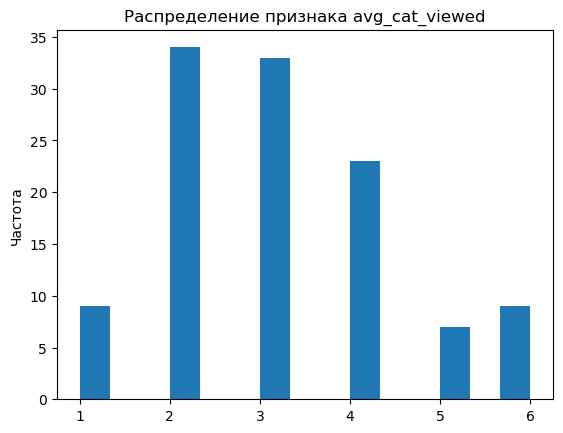

count    115.000000
mean       3.104348
std        1.327006
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        6.000000
Name: avg_cat_viewed, dtype: float64


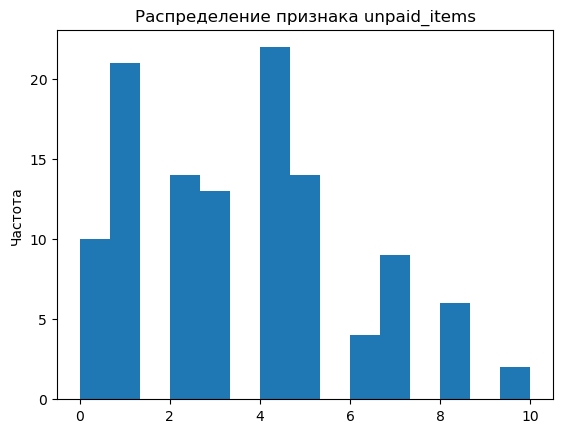

count    115.000000
mean       3.486957
std        2.418370
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       10.000000
Name: unpaid_items, dtype: float64


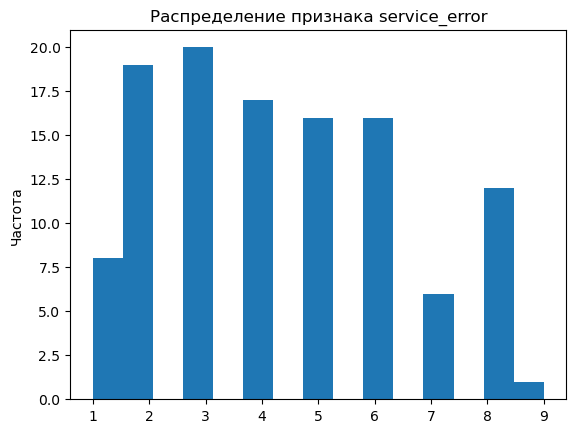

count    115.000000
mean       4.321739
std        2.109077
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max        9.000000
Name: service_error, dtype: float64


In [29]:
for feature in (market_df.drop(['id', 'current_month_activity', 'pages_per_visit'], axis=1)
                .select_dtypes(include='number')):
    display_hist(market_df[market_df['pages_per_visit'] == 5], feature)

Изучение распределений признаков не показало аномальности в данных, а значит, наиболее вероятно, что это данные со средним количеством просмотренных страниц, равным 5, в большей части не отличаются от всех данных. Их количество 115.

Повторим анализ для данных, где среднее количество просмотренных страниц 11.

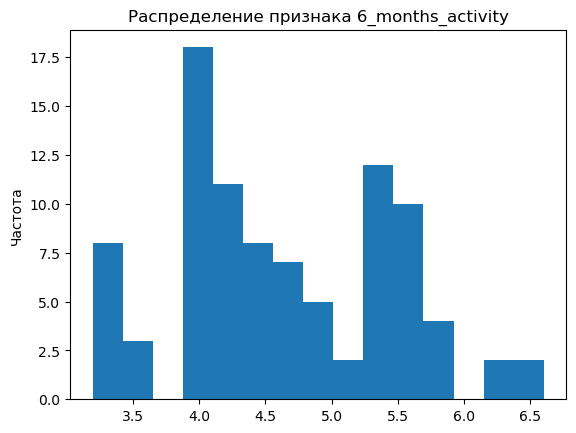

count    92.000000
mean      4.635870
std       0.815183
min       3.200000
25%       4.000000
50%       4.400000
75%       5.400000
max       6.600000
Name: 6_months_activity, dtype: float64


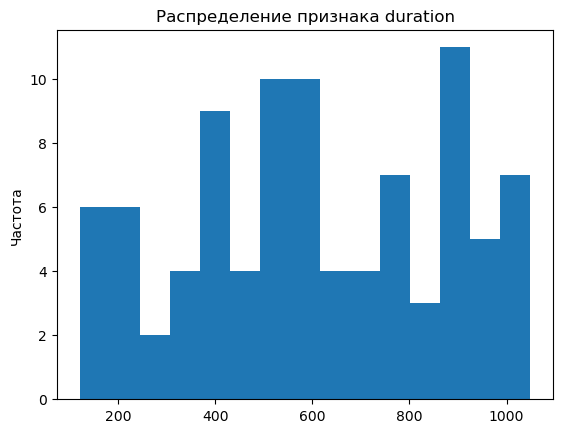

count      92.000000
mean      605.032609
std       263.085640
min       121.000000
25%       408.250000
50%       597.500000
75%       862.000000
max      1049.000000
Name: duration, dtype: float64


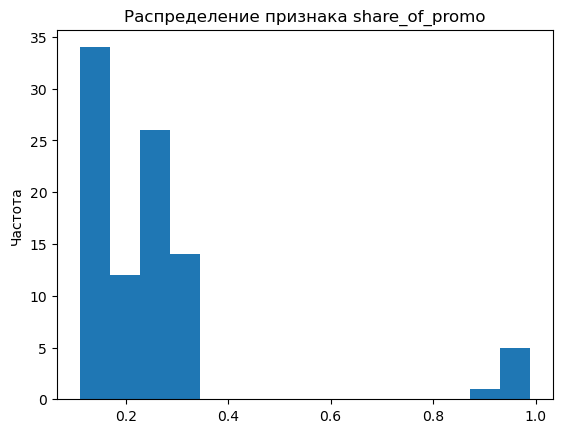

count    92.000000
mean      0.253804
std       0.194636
min       0.110000
25%       0.150000
50%       0.220000
75%       0.280000
max       0.990000
Name: share_of_promo, dtype: float64


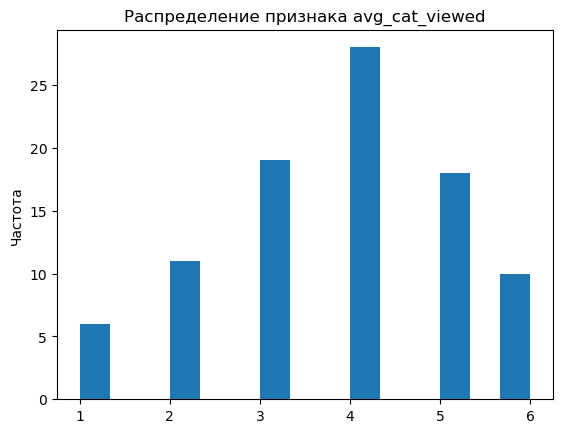

count    92.000000
mean      3.771739
std       1.367626
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       6.000000
Name: avg_cat_viewed, dtype: float64


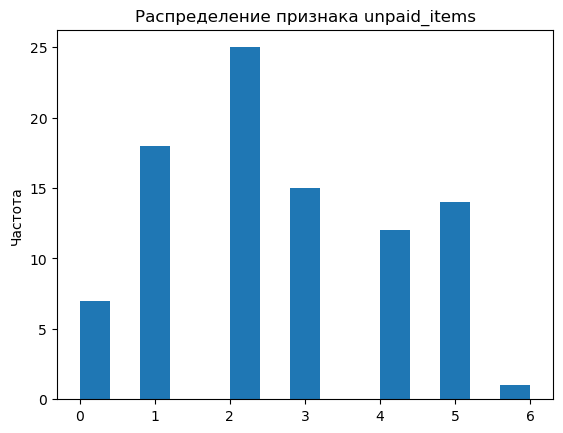

count    92.000000
mean      2.576087
std       1.556508
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       6.000000
Name: unpaid_items, dtype: float64


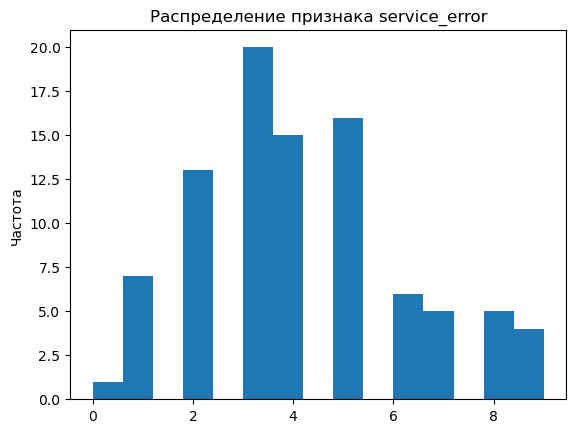

count    92.000000
mean      4.130435
std       2.134064
min       0.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       9.000000
Name: service_error, dtype: float64


In [30]:
for feature in (market_df.drop(['id', 'current_month_activity', 'pages_per_visit'], axis=1)
                .select_dtypes(include='number')):
    display_hist(market_df[market_df['pages_per_visit'] == 11], feature)

Изучение распределений признаков не показало аномальности в данных, а значит, наиболее вероятно, что это данные со средним количеством просмотренных страниц, равным 11, в большей части не отличаются от всех данных. Их количество 92. С пиками в среднем количестве просмотренных страниц разобрались. Можно двигаться дальше.

#### Количество маркетинговых активностей в текущем месяце

Так как гистограмма не очень подходит для визуализации маркетинговой активности в текущем месяце, ее представим в виде столбчатой диаграммы и изучим детальнее

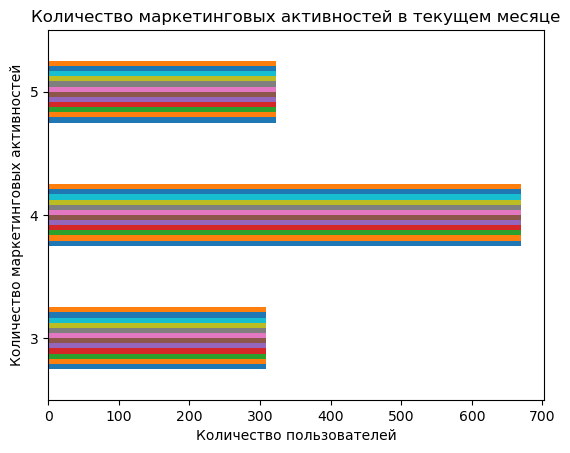

In [31]:
market_df.groupby('current_month_activity').count().plot(kind='barh', legend=False)
plt.title('Количество маркетинговых активностей в текущем месяце')
plt.ylabel('Количество маркетинговых активностей')
plt.xlabel('Количество пользователей')
plt.show()

**Вывод:** 
- Все пользователи получили от 3 до 5 маркетинговых активностей в течение текущего месяца
- Большая часть пользователей получили 4

Анализ количественных признаков завершен. Можно переходить к категориальным.

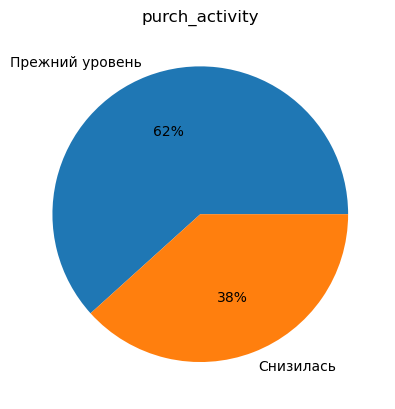

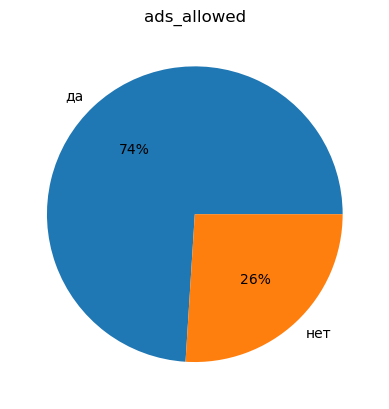

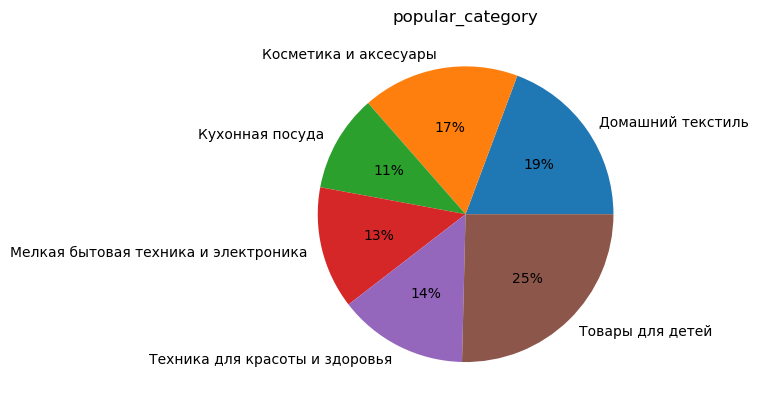

In [32]:
cat_features = ['purch_activity', 'ads_allowed', 'popular_category']

for feature in cat_features:
    (market_df.pivot_table(index=feature, values='id', aggfunc='count')
     .plot(kind='pie', y='id', x=feature, legend=False, autopct='%1.0f%%'))
    plt.title(f'{feature}')
    plt.ylabel('')

**Покупательская активность (целевой признак)**
- Классовый дисбаланс не критичен (62% - не снизилась и 38% - снизилась)

**Согласие получать рекламу**
- 74% пользователей согласны получать рекламные уведомления

**Популярные категории**
- Самые популярные категории - `товары для детей` (25%), `домашний текстиль` (19%) и `косметика и аксесуары` (17%)

### market_money_df

In [33]:
market_money_df.head()

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


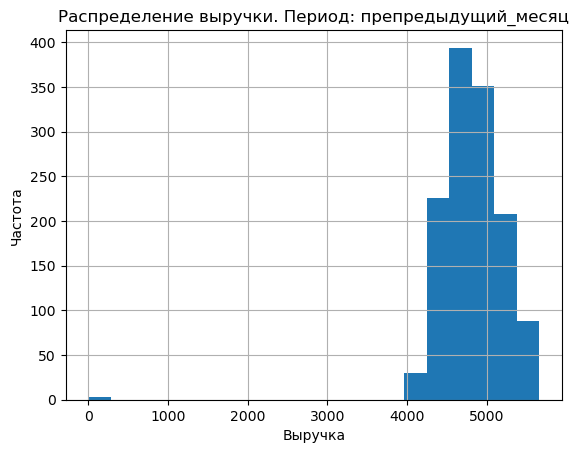

count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: revenue, dtype: float64


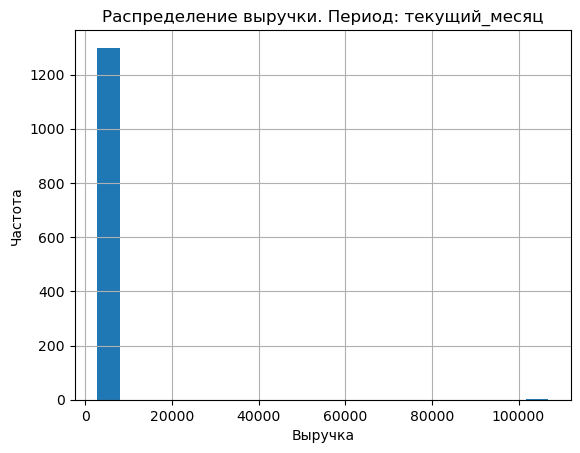

count      1300.000000
mean       5314.960846
std        2939.708156
min        2758.700000
25%        4706.050000
50%        5179.950000
75%        5761.725000
max      106862.200000
Name: revenue, dtype: float64


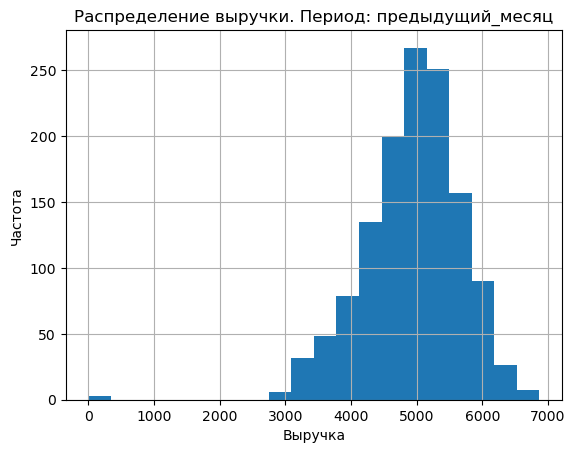

count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: revenue, dtype: float64


In [34]:
for period in market_money_df['period'].unique():
    market_money_df.loc[market_money_df['period'] == period, 'revenue'].hist(bins=20)
    plt.title(f'Распределение выручки. Период: {period}')
    plt.ylabel('Частота')
    plt.xlabel('Выручка')
    plt.show()
    print(market_money_df.loc[market_money_df['period'] == period, 'revenue'].describe())

Обнаружено аномальное значение выручки 106 862, судя по всему, это значение как-то оказалось в каждом из периодов. изучим его детально.

In [35]:
market_money_df.loc[market_money_df['revenue'] > 100000]

,id,period,revenue
98,215380,текущий_месяц,106862.2


- Кто-то потратил в интернет-магазине 106 тысяч. Значение реалистично, но для нашего исследования оно только помешает обучению модели, то есть это выброс. Заменим это значение 95-м квартилем.
- В предыдущем и препредыдущем месяцах также есть выбросы - нули. Кто-то не тратил деньги совсем, и эти клиенты нас не интересуют по условию. Удалим эти строки.

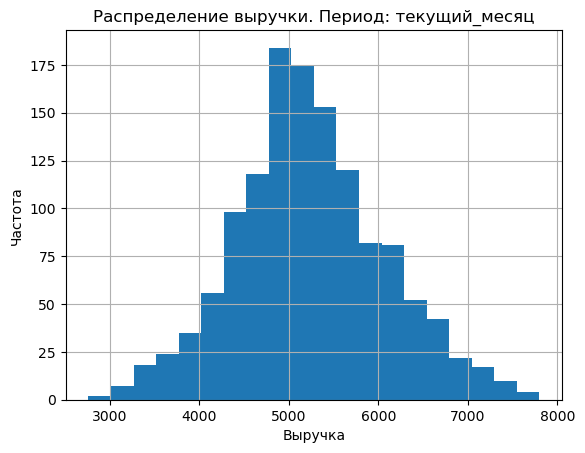

count    1300.000000
mean     5237.548788
std       835.604047
min      2758.700000
25%      4706.050000
50%      5179.950000
75%      5761.725000
max      7799.400000
Name: revenue, dtype: float64


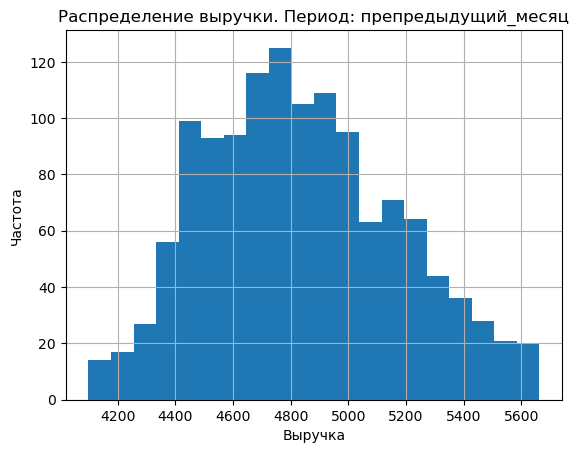

count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: revenue, dtype: float64


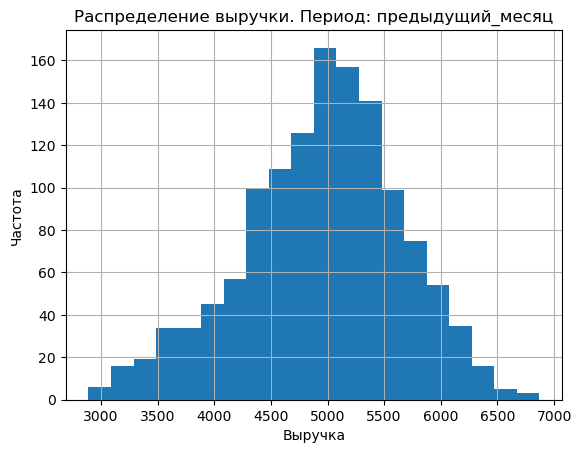

count    1297.000000
mean     4948.339630
std       701.228571
min      2890.000000
25%      4498.500000
50%      5005.500000
75%      5409.000000
max      6869.500000
Name: revenue, dtype: float64


In [36]:
# Замена значений
market_money_df.loc[market_money_df['revenue'] > 100000, 'revenue']\
= np.quantile(market_money_df['revenue'], 0.95)

# Удаление клиентов без активности в течение 3 месяцев
market_money_df = market_money_df.drop(market_money_df[market_money_df['revenue'] == 0].index)

for period in market_money_df['period'].unique():
    market_money_df.loc[market_money_df['period'] == period, 'revenue'].hist(bins=20)
    plt.title(f'Распределение выручки. Период: {period}')
    plt.ylabel('Частота')
    plt.xlabel('Выручка')
    plt.show()
    print(market_money_df.loc[market_money_df['period'] == period, 'revenue'].describe())

**Выручка в препредыдущем месяце**
- Распределение похоже на нормальное со средним 4834
- Выбросы и аномалии отсутствуют

**Выручка в текущем месяце**
- Распределение похоже на нормальное со средним 5251
- Выбросы и аномалии отсутствуют

**Выручка в предыдущем месяце**
- Распределение похоже на нормальное со средним 4968
- Выбросы и аномалии отсутствуют

### market_money_df
Аналогично предыдущему шагу, разделим данные на периоды

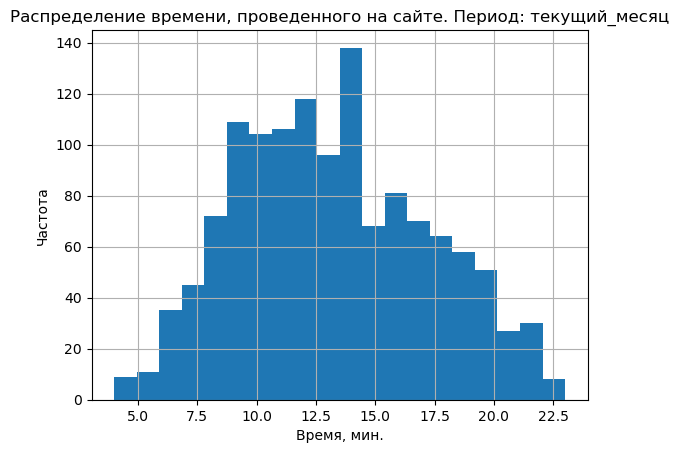

count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64


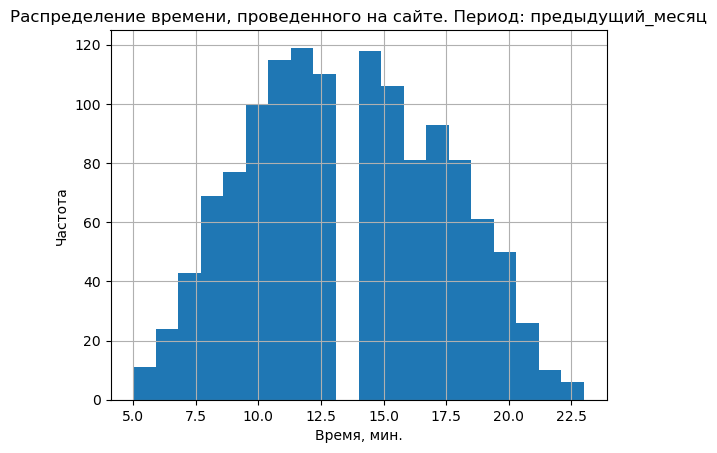

count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: minutes, dtype: float64


In [37]:
for period in market_time_df['period'].unique():
    market_time_df.loc[(market_time_df['period'] == period), 'minutes'].hist(bins=20)
    plt.title(f'Распределение времени, проведенного на сайте. Период: {period}')
    plt.ylabel('Частота')
    plt.xlabel('Время, мин.')
    plt.show()
    print(market_time_df.loc[market_time_df['period'] == period, 'minutes'].describe())

**Время на сайте в текущем месяце**
- Распределение времени похоже на нормальное со средним 13.3 минуты
- Аномалии и выбросы отсутствуют

**Время на сайте в прошлом месяце**
- Распределение времени похоже на нормальное со средним 13.4 минуты
- Аномалии и выбросы отсутствуют

### money_df
Визуализируем распределение прибыли

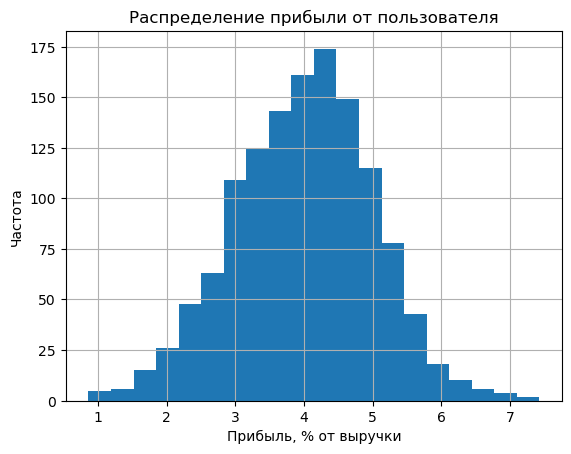

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: profit, dtype: float64

In [38]:
money_df['profit'].hist(bins=20)
plt.ylabel('Частота')
plt.xlabel('Прибыль, % от выручки')
plt.title('Распределение прибыли от пользователя')
plt.show()
money_df['profit'].describe()

**Распределение прибыли**
- Распределение напоминает нормальное, среднее почти 4% от выручки
- Аномалии и выбросы отсутствуют

**Общий вывод по Исследовательскому анализу данных:**

- В данных отсутствуют аномалии и выбросы

**Анализ входных признаков:**

- **Среднемесячное количество маркетинговых коммуникаций за 6 месяцев:** Распределение имеет форму, не похожую на нормальное. Основная масса клиентов в среднем получают до 5.75 коммуникаций со сторроны сервиса (3й квартиль). Среднее значение 4.2, медиана также 4.2. На графике в этом диапазоне заметен пик, то есть значение 4.2 также является и модой. Обратим внимание, что клиенты редко получают в среднем больше 6 или меньше 2 маркетинговых взаимодействия со стороны сервиса.
- **Количество дней, которое прошло с момента регистрации на сайте:** По форме распределение напоминает нормально, со средним около 601
- **Доля акционных товаров среди всех покупок:** В левой части графика находится большинство пользователей - них доля акционных товаров не превышает 0.3 (3й квартиль, 75%), само распределение походит на нормальное со средним 2.5, но есть также группа пользователей, у которых почти все купленные товары являются акционными (правая часть графика). Вероятно, это связано с тем, что у сайта есть пользователи, которые "охотятся" за акциями.
- **Среднее количество просмотренных категорий:** Распределение похоже на нормальное, со средним 3.
- **Неоплаченные товары в корзине:** Распределение похоже на нормальное со смещением влево, средним 2.8. Обратим внимание, что у большинства пользователей количество неоплаченных товаров в корзине не превышает 4 (75%)
- **Сбои сервиса:** Форма распределения напоминает нормальное, со средним 4.2. 
- **Среднее количество просмотренных страниц за визит:** Форма распределения напоминает нормальное со средним 7.5, но два пика 5 и 11 не могут нам позволить так считать. Изучим эти данные детальнее.
- Большая часть пользователей (75%) не посещают в среднем более 11 страниц за визит.
- **Количество маркетинговых активностей в текущем месяце:** Все пользователи получили от 3 до 5 маркетинговых активностей в течение текущего месяца. Большая часть пользователей получили 4.
- **Выручка в препредыдущем месяце:** Распределение похоже на нормальное со средним 4834
- **Выручка в текущем месяце:** Распределение похоже на нормальное со средним 5251
- **Выручка в предыдущем месяце:** Распределение похоже на нормальное со средним 4968
- **Распределение прибыли:** Распределение напоминает нормальное, среднее почти 4% от выручки
- **Время на сайте в текущем месяце:** Распределение времени похоже на нормальное со средним 13.3 минуты
- **Время на сайте в прошлом месяце:** Распределение времени похоже на нормальное со средним 13.4 минуты
- **Согласие получать рекламу:** 74% пользователей согласны получать рекламные уведомления
- **Популярные категории:** Самые популярные категории - `товары для детей` (25%), `домашний текстиль` (19%) и `косметика и аксесуары` (17%)

**Анализ целевого признака:** 

**Покупательская активность:** Классовый дисбаланс не критичен (62% - не снизилась и 38% - снизилась)

## Объединение таблиц

Для разработки модели МО, которая позволит нам прогнозировать покупательскую способность, необходимо объединить данные в одну таблицу (кроме данных о прибыли).

Сразу проверим результат: выведем 5 строк итоговой таблицы и проверим, все ли данные присоединены корректно.

In [39]:
# Объединим таблицы с помощью сводных таблиц
market_money_piv = market_money_df.pivot_table(index='id', columns='period', values='revenue', aggfunc='sum').reset_index()
market_df = market_df.merge(market_money_piv, on='id', how='inner')
market_df = market_df.rename(columns={'предыдущий_месяц': 'revenue_previous_month', 'препредыдущий_месяц': 'revenue_month_before_previous', 'текущий_месяц': 'revenue_current_month'})

market_time_piv = market_time_df.pivot_table(index='id', columns='period', values='minutes', aggfunc='sum').reset_index()
market_df = market_df.merge(market_time_piv, on='id', how='inner')
market_df = market_df.rename(columns={'предыдущий_месяц': 'minutes_previous_month', 'текущий_месяц': 'minutes_current_month'})

# Пропуски возникнут в ячейках, когда пользователь 
# ничего не покупал в конкретном месяце, такие данные нам не интересны по условию
market_df = market_df.dropna(axis=0)

# Добавим новую колонку для хранения закодированного значения целевого признака
market_df.loc[market_df['purch_activity'] == 'Снизилась', 'purch_act'] = 1
market_df.loc[market_df['purch_activity'] != 'Снизилась', 'purch_act'] = 0
market_df['purch_activity'] = market_df['purch_act']
market_df = market_df.drop('purch_act', axis=1)

market_df.head()

,id,purch_activity,service_type,ads_allowed,6_months_activity,current_month_activity,duration,share_of_promo,popular_category,avg_cat_viewed,unpaid_items,service_error,pages_per_visit,revenue_previous_month,revenue_month_before_previous,revenue_current_month,minutes_previous_month,minutes_current_month
1,215349,1.0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,1.0,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,1.0,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,1.0,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,1.0,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [40]:
market_df.shape

(1297, 18)

Соединение таблиц выполнено.

## Корреляционный анализ 

Проведем корреляционный анализ, для оценки зависимостей между признаками будем использовать phik, так как не все наши признаки имеют нормальное распределение, а также phik позволяет увидеть не только линейные зависимости.

Построим тепловую карту на основании матрицы корреляций phik. Напомним: целевой признак - `purch_activity`

In [41]:
market_df

,id,purch_activity,service_type,ads_allowed,6_months_activity,current_month_activity,duration,share_of_promo,popular_category,avg_cat_viewed,unpaid_items,service_error,pages_per_visit,revenue_previous_month,revenue_month_before_previous,revenue_current_month,minutes_previous_month,minutes_current_month
1,215349,1.0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,1.0,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,1.0,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,1.0,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,1.0,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,0.0,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,0.0,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,0.0,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,0.0,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


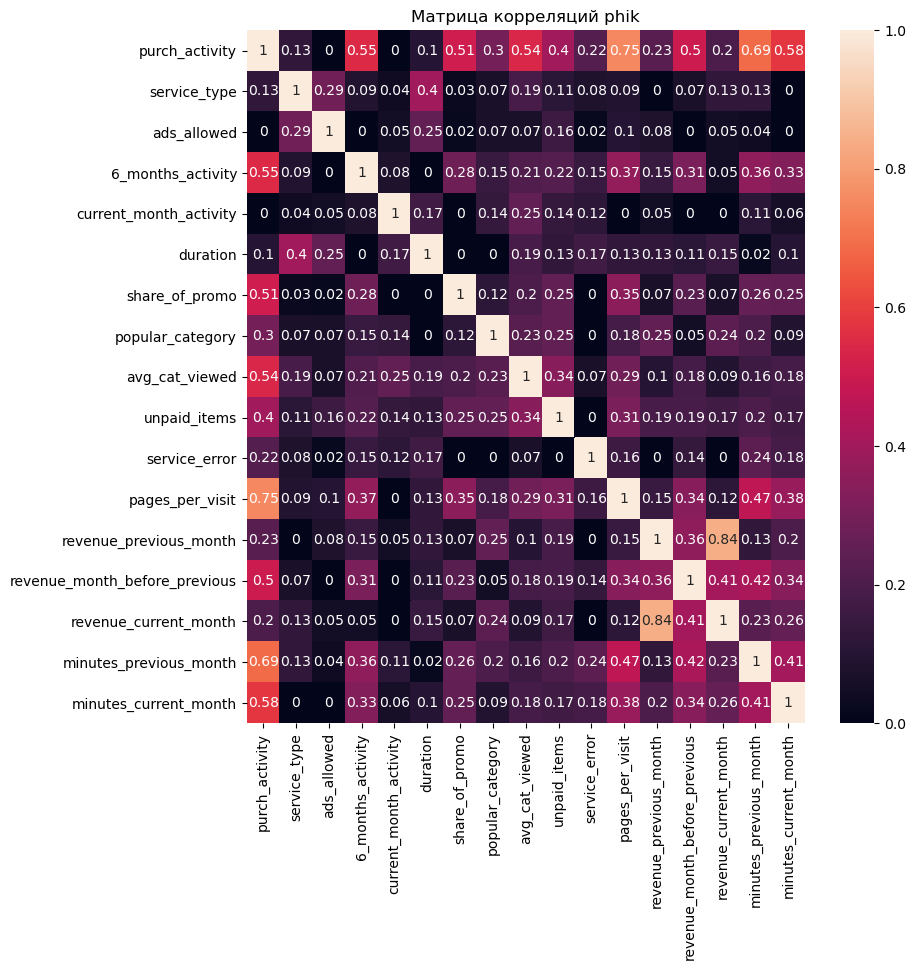

In [42]:
matrix = market_df.drop('id', axis=1).phik_matrix(interval_cols=['6_months_activity',
                                    'duration', 'share_of_promo',
                                    'revenue_month_before_previous',
                                    'revenue_previous_month',
                                    'revenue_current_month',
                                    'minutes_previous_month',
                                    'minutes_current_month'
                                    ]).round(2)
plt.figure(figsize=(9,9))
sns.heatmap(data=matrix, annot=True)
plt.title('Матрица корреляций phik')
plt.show()

**Интерпретация тепловой карты:**

Выделим признаки, которые наиболее сильно влияют на целевой (покупательская активность)
- `Маркетинговая активность за 6 мес.` - заметная зависимость (коэфф. 0.55)
- `Доля акционных товаров` - заметная зависимость (коэфф. 0.5)
- `Среднее количество просмотренных категорий` - заметная зависимость (коэфф. 0.5)
- `Количество не оплаченных товаров в корзине` - заметная зависимость (коэфф. 0.5)
- `Количество просмотренных страниц` - сильная зависимость (коэфф. 0.75)
- `Выручка в препредыдущем месяце` - заметная зависимость (коэфф. 0.5)
- `Время, проведенное на сайте в предыдущем и текущем месяцах` - заметная зависимость (коэфф. 0.68 и 0.58)

Мультиколлинеарность отсутствует.

## Обучение моделей

Обучим модели машинного обучения для прогнозирования целевого признака - `Покупательской активности`. Будем использовать модели логистическая регрессия, метод k-ближайших соседей, дерево решений, метод опорных векторов. Для обучения моделей будем использовать пайплайны. Отберем среди всех моделей лучшую.

In [43]:
# Списки для хранения столбцов количественных и категориальных переменных
RANDOM_STATE = 42
ohe_columns = ['popular_category', 'ads_allowed']
ord_columns = ['service_type']
num_columns = [
    '6_months_activity', 'current_month_activity',
    'duration', 'share_of_promo', 'avg_cat_viewed',
    'unpaid_items', 'service_error', 'pages_per_visit',
    'revenue_month_before_previous', 'revenue_previous_month',
    'revenue_current_month', 'minutes_previous_month',
    'minutes_current_month'
]

# id поместим в индекс, чтобы он не мешал обучению. 
market_df.set_index('id')

X_train, X_test, y_train, y_test = train_test_split(
    market_df.drop(['purch_activity'], axis=1),
    market_df['purch_activity'],
    random_state=RANDOM_STATE,
    test_size=0.25,
    stratify=market_df['purch_activity']
)

In [44]:
# Пайплайны
ohe_pipe = Pipeline(
    [
        ('ohe_cat', OneHotEncoder(drop='first', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('ord_cat', OrdinalEncoder(categories=[['стандарт', 'премиум']]))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe_cat', ohe_pipe, ohe_columns),
        ('ord_cat', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ]
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [45]:
# Словари с подбором гиперпараметров Моделей:
models_params = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__min_samples_split': range(2, 10),
     'models__min_samples_leaf': range(1, 10),
     'models__max_depth': range(2, 8),
     'preprocessor__num': [StandardScaler(), MinMaxScaler()]},
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(3, 25),
     'preprocessor__num': [StandardScaler(), MinMaxScaler()]},
    {'models': [LogisticRegression(random_state=RANDOM_STATE)],
     'models__C': range(1, 10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler()]},
    {'models': [SVC(probability=True, random_state=RANDOM_STATE)],
     'models__kernel': ['poly', 'sigmoid', 'rbf'],
     'preprocessor__num': [StandardScaler(), MinMaxScaler()]},
]

Так как для нас необходимо всем объектам с классом 1 (активность снизилась) присвоить верно класс 1, будем использовать **взвешенную f1-меру с повышенным вниманием к recall**, так как для нас критично не пропускать клиентов, у которых потенциально может снизиться активность.

In [46]:
# Метрика для выбора гиперпараметров модели
def custom_metric(y_true, y_pred):
    return(fbeta_score(y_true, y_pred, beta=10, pos_label=1))

fbeta_scorer = make_scorer(
    custom_metric,
    greater_is_better=True
)

In [47]:
# Подбор оптимальной модели и гиперпараметров
search = RandomizedSearchCV(
    pipe_final,
    models_params,
    cv=5,
    scoring=fbeta_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search.fit(X_train, y_train)

final_model = search.best_estimator_
y_pred = final_model.predict(X_test)
y_test_probas = final_model.predict_proba(X_test)

print(f'Лучшее значение метрики f1 на тренировочной выборке: {search.best_score_}')
print(f'Значение f1 на тестовой выборке: {custom_metric(y_test, y_pred)}')
print(f'Значение accuracy на тестовой выборке: {accuracy_score(y_test, y_pred)}\nМодель:')
print(final_model)

Лучшее значение метрики f1 на тренировочной выборке: 0.7234981076011168
Значение f1 на тестовой выборке: 0.7506593143131144
Значение accuracy на тестовой выборке: 0.8430769230769231
Модель:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe_cat',
                                                  Pipeline(steps=[('ohe_cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['popular_category',
                                                   'ads_allowed']),
                                                 ('ord_cat',
                                                  Pipeline(steps=[('ord_cat',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                    

**Выводы по Моделированию:**
- Лучшая модель - Дерево решений с максимальной глубиной 6 и минимальным количеством объектов для узла 5, а минимальное количество объектов в листе - 4.
- Метрика accuracy у лучшей модели - 0.84, а взвешенная f1-мера (уклон в recall) 0.75.

## Анализ важности признаков

Для анализа важности признаков будем использовать график shap.plots.beeswarm

Using 972 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████| 150/150 [05:31<00:00,  2.21s/it]


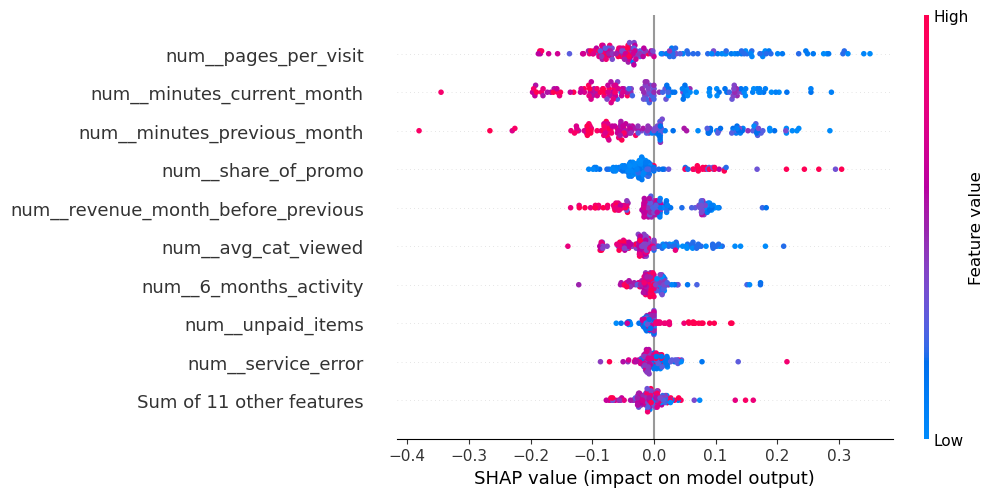

In [49]:
# Обработаем данные препроцессором лучшей модели
X_train_encoded = pd.DataFrame(data=search.best_estimator_['preprocessor'].transform(
    X_train), columns=search.best_estimator_['preprocessor'].get_feature_names_out())

explainer = shap.KernelExplainer(
    model=search.best_estimator_['models'].predict_proba,
    data=X_train_encoded,
    feature_name=search.best_estimator_['preprocessor'].get_feature_names_out()
)

# Используем shap.sample(data, 150), тк 975 строк обрабатываются 30 минут реального времени
shap_values = explainer(shap.sample(X_train_encoded, 150))
shap.plots.beeswarm(shap_values[:, :, 1])

**Интерпретация графика:**
- Сильнее всего на целевой признак влияет количество проведенного времени на сайте в прошлом месяце, при том чем меньше времени пользователь проводил на сайте, тем с большей вероятностью модель отнесет его к классу 1 (снизилась активность). Аналогично с 4-м по значимости признаку - время, проведенное пользователем на сайте в текущем месяце.
- Второй по важности признак - количество просмотренных странц при посещении сайта: чем меньше этот показатель, тем с большей вероятностью модель отнесет его к классу 1 (снизилась активность)
- Третий по важности признак - доля акционных товаров среди покупок. Чем выше этот показатель, тем с большей вероятностью модель отнесет пользователя к классу 1 (снизилась активность). Это может говорить нам о том, что на сайт приходит определенное количество пользователей только за акционным товаром, и далее ничего не покупает.
- Низкое количество маркетинговой активности к пользователю также будет склонять модель к отнесению пользователя к классу 1 (снизилась активность), как и среднее количество просмотренных пользователем категорий
- По логике модели, более давние пользователи сайта больше подвержены снижению активности (предпоследняя строка: чем выше значение количества дней с момента регистрации, тем с большей вероятностью модель присвоит пользователю класс 1 (снизилась активность))
- График говорит о том, что чем выше выручка в препредыдущем месяце, тем с большей вероятностью модель отнесет пользователя к классу 1 (снизилась активность). В связи с предположением на основании доли акционных товаров среди купленных, необходимо проверить, не проводилось ли массовых акций в препредыдущем месяце.
- Остальные признаки мало значимы для модели

**Рекомендации:**
- Чтобы у давних клиентов сайта сохранялась покупательская способность, рекомендуем чаще направлять им предложения (увеличить среднюю маркетинговую активность). Также необходимо увеличить время, проводимое на сайте, можно это сделать, если рекомендации и предложения будут обязательно включать любимую категорию пользователя, но не только ее (небольшое разнообразие в предложенных категориях повышает вероятность присваивания класса 0).
- Необходимо снизить количество неоплаченных товаров в корзине у пользователей - можно разослать персональные предложения со скидкой на продукцию из их корзины клиентам, у которых долгое время в корзине лежит не оплаченный товар. Это позволит их смотивировать купить быстрее и, как следствие, не потерять активность
- Необходимо проверить, какие промо-акции проводились в препредыдущем месяце и сопоставить результаты с результатами работы модели - может выясниться, что спланированная (*например, кампания для быстрого сбыта неходового товара точно испортила бы статистику*) маркетинговая кампания принесла много покупок акционного товара, что сейчас портит статистику. Если подобных кампаний не проводилось, можно попробовать разослать клиентам с высокой выручкой в препредыдущем месяце персональные предложения, которые будут обязательно включать любимую категорию пользователя, но не только ее.

## Сегментация покупателей

Проведем сегментацию пользователей по вероятности снижения активности и прибыльности. Будем использовать скаттерплот для визуализации.

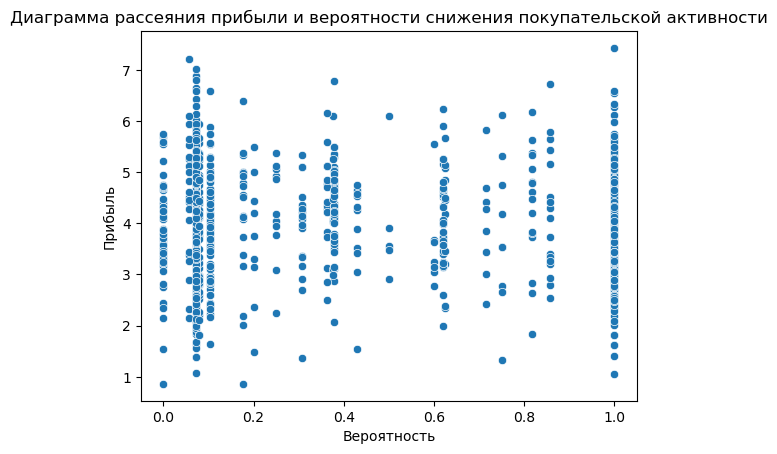

In [50]:
# Предскажем вероятности для всех строк датафрейма
X = market_df.drop('purch_activity', axis=1)
probas = final_model.predict_proba(X)[:,1]
report = pd.Series(probas, name='probability')
market_df['probability'] = report
market_df = market_df.merge(money_df, on='id', how='inner')

sns.scatterplot(data=market_df, x='probability', y='profit')
plt.title('Диаграмма рассеяния прибыли и вероятности снижения покупательской активности')
plt.xlabel('Вероятность')
plt.ylabel('Прибыль')
plt.show()

#### Сравнение сегмента со всеми клиентами

Основной группой пользователей выберем тех, для кого модель прогнозирует вероятность снижения активности 0.6 и больше, а также с прибылью больше или равной 4 (среднее значение). Сравним выбранный сегмент с остальными клиентами.

In [51]:
segment = market_df.loc[(market_df['probability'] >= 0.6)&(market_df['profit'] >= 4)]

Отобразим на графиках распределение количественных признаков сегмента и наложим на них гистограммы распределения признаков всех строк.

Синие гистограммы - все данные, зеленые - наш сегмент.

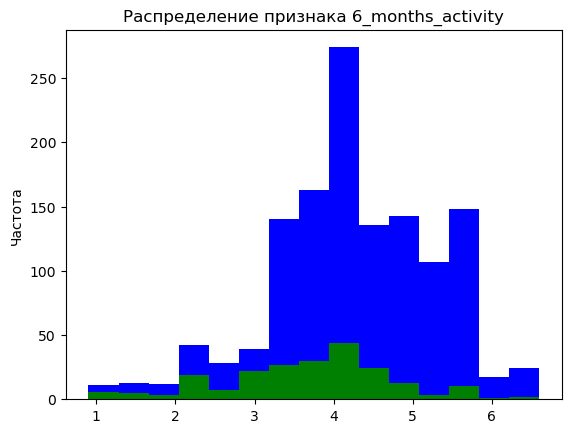

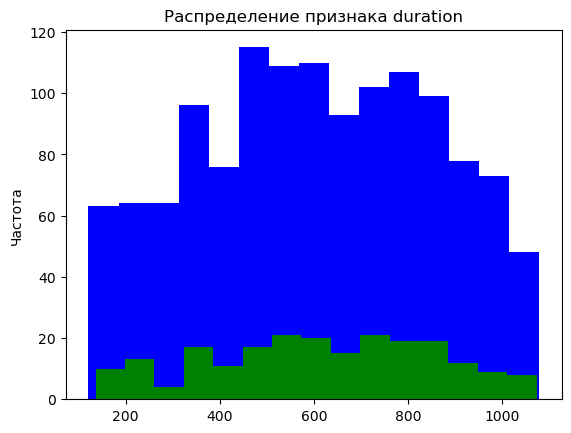

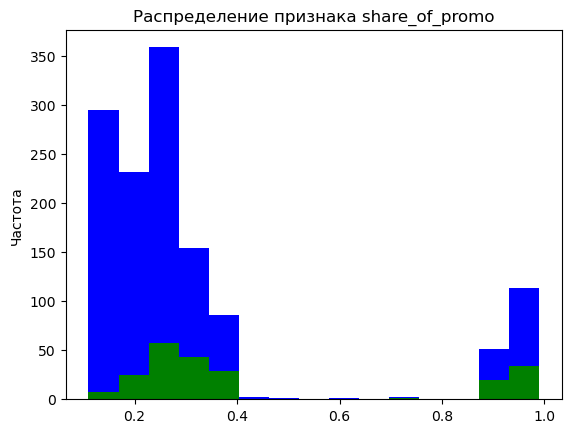

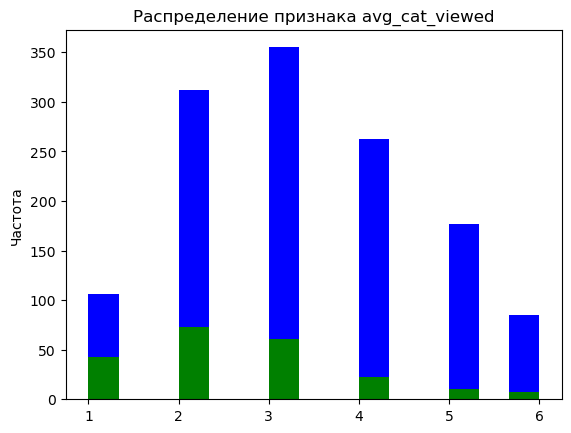

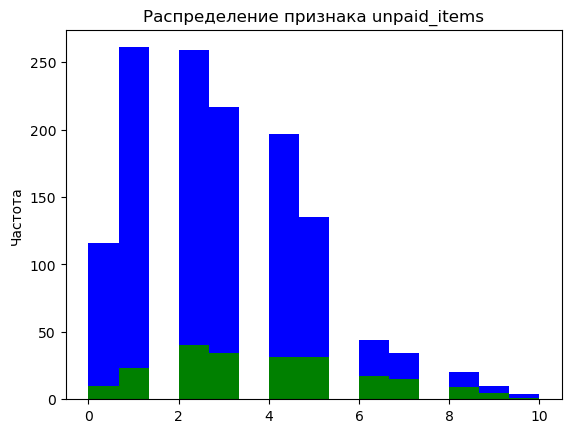

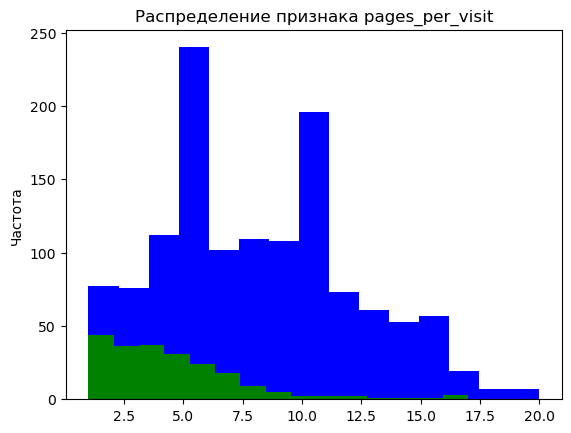

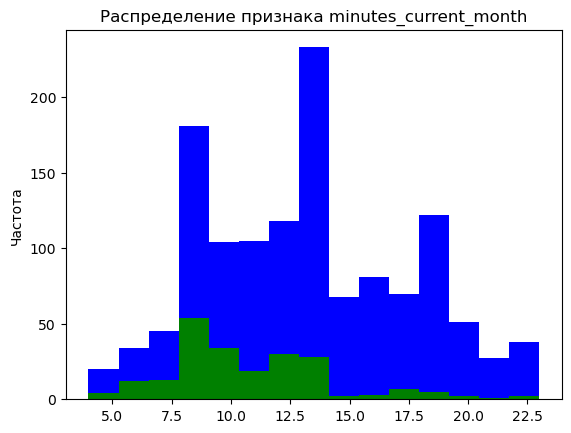

In [52]:
for feature in ['6_months_activity', 'duration', 'share_of_promo', 'avg_cat_viewed', 'unpaid_items', 'pages_per_visit', 'minutes_current_month']:
    market_df[feature].plot(kind='hist', y=feature, bins=15, color='b')
    segment[feature].plot(kind='hist', y=feature, bins=15, color='g')
    plt.title(f'Распределение признака {feature}')
    plt.ylabel('Частота')
    plt.show()

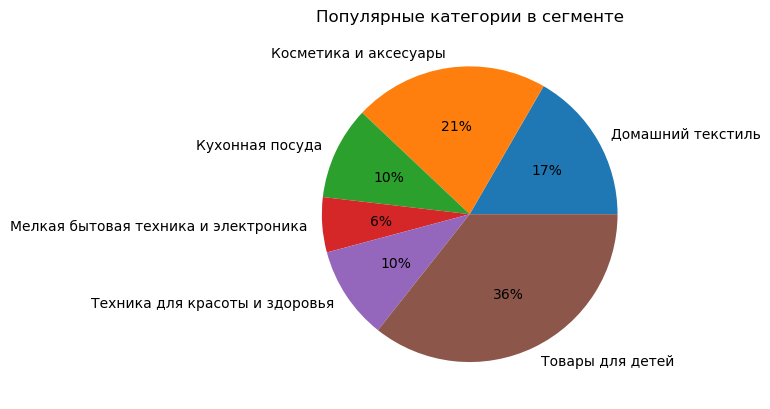

In [53]:
(segment.pivot_table(index='popular_category', values='id', aggfunc='count')
     .plot(kind='pie', y='id', x='popular_category', legend=False, autopct='%1.0f%%'))
plt.title('Популярные категории в сегменте')
plt.ylabel('')
plt.show()

**Выводы по сравнению:**
- Многие клиенты не получали много предложений от магазина, можно увеличить показатель среднемесячной активности
- Распределение давних клиентов и новых в сегменте очень похоже на распределение во всем множестве клиентов
- Среди клиентов сегмента многие имеют высокие показатели акционного товара среди покупок. 
- Большинство клиентов просматривают 2-3 категории за сессию, это меньше, чем средние клиенты во всей совокупности
- Многие клиенты из сегмента имеют неоплаченные товары в корзине
- Клиенты из сегмента просматривают очень мало страниц в сравнении со всеми клиентами (их показатель 2.5 - 7 страниц, в то время как среднее по всей совокупности - 8
- Среднее время нахождения на сайте в сегменте - около 10 минут, его также можно увеличить
- Наиболее популярные категории - товары для детей, косметика и аксесуары

**Рекомендации:**
- Необходимо направлять клиентам из сегмента больше персонализированных предложений, которые будут включать товары из их любимой категории, но не только из нее (чтобы увеличить количество просматриваемых категорий). В подборку/предложение помимо любимой категории можно включить самые популярные категории: товары для детей, косметика и аксесуары. Это решение одновременно повлияет на несколько признаков и уменьшит вероятность снижения активности клиентов из сегмента.
- Так как в сегменте сравнительно много клиентов с неоплаченными товарами в корзине, можно разослать им купоны на скидку на товары в корзине, это смотивирует их купить "здесь и сейчас", а активность не снизится.
- В каждое предложение лучше добавить несколько товаров из нескольких категорий, чтобы также потенциально повысились показатели времени, проведенного на сайте и количество просмотренных страниц.

## Общий вывод по проделанной работе
1. **Изучены данные, выполнена предобработка данных** (проверено наличие пропущенных значений, дубликатов)
2. **Проведен исследовательский анализ данных, изучены распределения признаков:**

    Входные признаки
    - **Среднемесячное количество маркетинговых коммуникаций за 6 месяцев:** Распределение имеет форму, не похожую на нормальное. Основная масса клиентов в среднем получают до 5.75 коммуникаций со сторроны сервиса (3й квартиль). Среднее значение 4.2, медиана также 4.2. На графике в этом диапазоне заметен пик, то есть значение 4.2 также является и модой. Обратим внимание, что клиенты редко получают в среднем больше 6 или меньше 2 маркетинговых взаимодействия со стороны сервиса.
    - **Количество дней, которое прошло с момента регистрации на сайте:** По форме распределение напоминает нормально, со средним около 601
    - **Доля акционных товаров среди всех покупок:** В левой части графика находится большинство пользователей - них доля акционных товаров не превышает 0.3 (3й квартиль, 75%), само распределение походит на нормальное со средним 2.5, но есть также группа пользователей, у которых почти все купленные товары являются акционными (правая часть графика). Вероятно, это связано с тем, что у сайта есть пользователи, которые "охотятся" за акциями.
    - **Среднее количество просмотренных категорий:** Распределение похоже на нормальное, со средним 3.
    - **Неоплаченные товары в корзине:** Распределение похоже на нормальное со смещением влево, средним 2.8. Обратим внимание, что у большинства пользователей количество неоплаченных товаров в корзине не превышает 4 (75%)
    - **Сбои сервиса:** Форма распределения напоминает нормальное, со средним 4.2. 
    - **Среднее количество просмотренных страниц за визит:** Форма распределения напоминает нормальное со средним 7.5, но два пика 5 и 11 не могут нам позволить так считать. Изучим эти данные детальнее.
    - Большая часть пользователей (75%) не посещают в среднем более 11 страниц за визит.
    - **Количество маркетинговых активностей в текущем месяце:** Все пользователи получили от 3 до 5 маркетинговых активностей в течение текущего месяца. Большая часть пользователей получили 4.
    - **Выручка в препредыдущем месяце:** Распределение похоже на нормальное со средним 4834
    - **Выручка в текущем месяце:** Распределение похоже на нормальное со средним 5251
    - **Выручка в предыдущем месяце:** Распределение похоже на нормальное со средним 4968
    - **Распределение прибыли:** Распределение напоминает нормальное, среднее почти 4% от выручки
    - **Время на сайте в текущем месяце:** Распределение времени похоже на нормальное со средним 13.3 минуты
    - **Время на сайте в прошлом месяце:** Распределение времени похоже на нормальное со средним 13.4 минуты
    - **Согласие получать рекламу:** 74% пользователей согласны получать рекламные уведомления
    - **Популярные категории:** Самые популярные категории - `товары для детей` (25%), `домашний текстиль` (19%) и `косметика и аксесуары` (17%)
    
    *(Целевой признак)* Покупательская активность: Классовый дисбаланс не критичен (62% - не снизилась и 38% - снизилась)

3. **Выполнен корреляционный анализ** при помощи матрицы коэффициентов phik. Мультиколлинеарность входных признаков отсутствует. Наиболее значимые признаки:
    - `Маркетинговая активность за 6 мес.` - заметная зависимость (коэфф. 0.55)
    - `Доля акционных товаров` - заметная зависимость (коэфф. 0.5)
    - `Среднее количество просмотренных категорий` - заметная зависимость (коэфф. 0.5)
    - `Количество не оплаченных товаров в корзине` - заметная зависимость (коэфф. 0.5)
    - `Количество просмотренных страниц` - сильная зависимость (коэфф. 0.75)
    - `Выручка в препредыдущем месяце` - заметная зависимость (коэфф. 0.5)
    - `Время, проведенное на сайте в предыдущем и текущем месяцах` - заметная зависимость (коэфф. 0.68 и 0.58)

4. **Обучены модели МО: Логистическая регрессия, SVC, Дерево решений, классификатор по методу ближайших соседей для прогнозирования снижения активности пользователей на основании входных признаков.** Проверены различные комбинации гиперпараметров, кодировщики StandardScaler, MinMaxScaler. Выбрана **лучшая модель** по метрике взвешенной f1-меры в сторону recall (так как для нас критичны ошибки 2 порядка: ложноотрицательные ответы в случае с тем, позитивный ответ - снизится активность): **Дерево решений с максимальной глубиной 6, минимальным количеством объектов для узла 5, минимальное количество объектов в листе - 4.** Метрика accuracy у лучшей модели - 0.84, а взвешенная f1-мера 0.75.

5. **Проведен анализ важности признаков**:
    - Сильнее всего на целевой признак влияет `количество проведенного времени на сайте в прошлом месяце`, при том чем меньше времени пользователь проводил на сайте, тем с большей вероятностью модель отнесет его к классу 1 (снизилась активность). Аналогично с 4-м по значимости признаку - `время, проведенное пользователем на сайте в текущем месяце`.
    - Второй по важности признак - `количество просмотренных странц при посещении сайта`: чем меньше этот показатель, тем с большей вероятностью модель отнесет его к классу 1 (снизилась активность)
    - Третий по важности признак - `доля акционных товаров среди покупок`. Чем выше этот показатель, тем с большей вероятностью модель отнесет пользователя к классу 1 (снизилась активность). Это может говорить нам о том, что на сайт приходит определенное количество пользователей только за акционным товаром, и далее ничего не покупает.
    - Низкое `количество маркетинговой активности` к пользователю также будет склонять модель к отнесению пользователя к классу 1 (снизилась активность), как и среднее количество просмотренных пользователем категорий
    - По логике модели, более давние пользователи сайта больше подвержены снижению активности (предпоследняя строка: чем выше значение количества дней с момента регистрации, тем с большей вероятностью модель присвоит пользователю класс 1 (снизилась активность))
    - График говорит о том, что чем выше выручка в препредыдущем месяце, тем с большей вероятностью модель отнесет пользователя к классу 1 (снизилась активность). В связи с предположением на основании доли акционных товаров среди купленных, необходимо проверить, не проводилось ли массовых акций в препредыдущем месяце.
    - Остальные признаки мало значимы для модели

6. **Проведена сегментация пользователей по прибыльности (больше 4) и вероятности снижения (0.6 и выше). Проведено сравнение сегмента со всей совокупностью клиентов. Получены следующие выводы:**
    - Многие клиенты не получали много предложений от магазина, можно увеличить показатель среднемесячной активности
    - Распределение давних клиентов и новых в сегменте очень похоже на распределение во всем множестве клиентов
    - Среди клиентов сегмента многие имеют высокие показатели акционного товара среди покупок. 
    - Большинство клиентов просматривают 2-3 категории за сессию, это меньше, чем средние клиенты во всей совокупности
    - Многие клиенты из сегмента имеют неоплаченные товары в корзине
    - Клиенты из сегмента просматривают очень мало страниц в сравнении со всеми клиентами (их показатель 2.5 - 7 страниц, в то время как среднее по всей совокупности - 8
    - Среднее время нахождения на сайте в сегменте - около 10 минут, его также можно увеличить
    - Наиболее популярные категории - товары для детей, косметика и аксесуары
    - **Рекомендации по работе с сегментом:**
        - Необходимо направлять клиентам из сегмента больше персонализированных предложений, которые будут включать товары из их любимой категории, но не только из нее (чтобы увеличить количество просматриваемых категорий). В подборку/предложение помимо любимой категории можно включить самые популярные категории: товары для детей, косметика и аксесуары. Это решение одновременно повлияет на несколько признаков и уменьшит вероятность снижения активности клиентов из сегмента.
        - Так как в сегменте сравнительно много клиентов с неоплаченными товарами в корзине, можно разослать им купоны на скидку на товары в корзине, это смотивирует их купить "здесь и сейчас", а активность не снизится.
        - В каждое предложение лучше добавить несколько товаров из нескольких категорий, чтобы также потенциально повысились показатели времени, проведенного на сайте и количество просмотренных страниц.

7. **Общие рекомендации для улучшения положения дел в части покупательской активности:**
    - Чтобы у давних клиентов сайта сохранялась покупательская способность, рекомендуем чаще направлять им предложения (увеличить среднюю маркетинговую активность). Также необходимо увеличить время, проводимое на сайте, можно это сделать, если рекомендации и предложения будут обязательно включать любимую категорию пользователя, но не только ее (небольшое разнообразие в предложенных категориях повышает вероятность присваивания класса 0).
    - Необходимо снизить количество неоплаченных товаров в корзине у пользователей - можно разослать персональные предложения со скидкой на продукцию из их корзины клиентам, у которых долгое время в корзине лежит не оплаченный товар. Это позволит их смотивировать купить быстрее и, как следствие, не потерять активность
    - Необходимо проверить, какие промо-акции проводились в препредыдущем месяце и сопоставить результаты с результатами работы модели - может выясниться, что спланированная (*например, кампания для быстрого сбыта неходового товара точно испортила бы статистику*) маркетинговая кампания принесла много покупок акционного товара, что сейчас портит статистику. Если подобных кампаний не проводилось, можно попробовать разослать клиентам с высокой выручкой в препредыдущем месяце персональные предложения, которые будут обязательно включать любимую категорию пользователя, но не только ее.